In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision; torchvision.__version__

'0.12.0'

In [11]:
vit_b_16 = models.vit_b_16(pretrained=True)

In [26]:
vit_b_16

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [43]:
state_dict = vit_b_16.state_dict()

In [48]:
state_dict.keys()

odict_keys(['class_token', 'conv_proj.weight', 'conv_proj.bias', 'encoder.pos_embedding', 'encoder.layers.encoder_layer_0.ln_1.weight', 'encoder.layers.encoder_layer_0.ln_1.bias', 'encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_0.ln_2.weight', 'encoder.layers.encoder_layer_0.ln_2.bias', 'encoder.layers.encoder_layer_0.mlp.linear_1.weight', 'encoder.layers.encoder_layer_0.mlp.linear_1.bias', 'encoder.layers.encoder_layer_0.mlp.linear_2.weight', 'encoder.layers.encoder_layer_0.mlp.linear_2.bias', 'encoder.layers.encoder_layer_1.ln_1.weight', 'encoder.layers.encoder_layer_1.ln_1.bias', 'encoder.layers.encoder_layer_1.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_1.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_1.self_attention.o

In [20]:
class Finetune(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = vit_b_16
        self.fc1 = nn.Linear(1000, 6)
        
    def forward(self, x):
        return self.fc1(self.vit(x))

In [36]:
model = Finetune()

In [27]:
import pandas as pd
import numpy as np
import sys
import torchvision
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
import os
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.utils import shuffle

In [28]:
labels = ['street', 'sea', 'mountain', 'glacier', 'forest', 'buildings']
image_size = (224, 224)

In [30]:
class Data(torch.utils.data.Dataset):
    def __init__(self, labels, image_size):
        self.data = []
        self.labels = []
        self.dir = 'D:/Data/intel/seg_train'
        
        i = 0
        for folder in os.listdir(self.dir):
            label = i
            for file in tqdm(os.listdir(os.path.join(self.dir, folder))):
                img_path = os.path.join(os.path.join(self.dir, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.reshape(image, [3, 224, 224])
                image = image / 255 #normalize
                 
                # Append the image and its corresponding label to the output
                self.data.append(image)
                self.labels.append(label)
            i += 1
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [32]:
data = Data(labels, image_size)

100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:04<00:00, 477.57it/s]


In [33]:
train, val = torch.utils.data.random_split(data, [11226, 2808])

In [34]:
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=8)
valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=8)

In [35]:
device = torch.device('cuda')
import torch.optim as optim

In [37]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [38]:
model.train()

Finetune(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (linear_1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU()
            (dropout_1): Dropout(p=0.0, inplace=False)
            (linear_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout_2): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (l

In [39]:
training_losses = []
val_losses = []
avg_training_losses = []
avg_val_losses = []

In [55]:
losses = []
for e in tqdm(range(50)):
    for x, y in trainloader:
        torch.cuda.empty_cache()
        x, y = x.to(device), y.to(device)
        x = x.float()
        
        # train step
        optimizer.zero_grad()
        y_pred = model(x)
        l = loss(y_pred, y)
        t_l = l.detach().cpu().numpy()
        l.backward()
        optimizer.step()
        
        training_losses.append(t_l)
    
    # with torch.no_grad() but this doesnt really make that big of a difference
    for i, j in valloader:
        # no optim zero grad, step, l.backward
        i, j = i.to(device), j.to(device)
        i = i.float()
        
        y_pred = model(i)
        ll = loss(y_pred, j)
        v_l = ll.detach().cpu().numpy()
        
        val_losses.append(v_l)
        
    avg_training_losses.append(np.mean(training_losses))
    avg_val_losses.append(np.mean(val_losses))
        
    print(f' *** Training Loss: {np.mean(training_losses)}, Validation Loss: {np.mean(val_losses)} *** ')

  2%|█▌                                                                              | 1/50 [04:19<3:31:57, 259.54s/it]

 *** Training Loss: 1.2645423412322998, Validation Loss: 1.1932920217514038 *** 


  4%|███▏                                                                            | 2/50 [08:40<3:28:12, 260.26s/it]

 *** Training Loss: 1.2410553693771362, Validation Loss: 1.1740763187408447 *** 


  6%|████▊                                                                           | 3/50 [13:04<3:25:16, 262.05s/it]

 *** Training Loss: 1.2205301523208618, Validation Loss: 1.1605725288391113 *** 


  8%|██████▍                                                                         | 4/50 [17:27<3:21:09, 262.38s/it]

 *** Training Loss: 1.203190565109253, Validation Loss: 1.1443004608154297 *** 


 10%|████████                                                                        | 5/50 [21:49<3:16:42, 262.28s/it]

 *** Training Loss: 1.185283899307251, Validation Loss: 1.1325994729995728 *** 


 12%|█████████▌                                                                      | 6/50 [26:12<3:12:37, 262.66s/it]

 *** Training Loss: 1.1693981885910034, Validation Loss: 1.1203306913375854 *** 


 14%|███████████▏                                                                    | 7/50 [30:37<3:08:45, 263.38s/it]

 *** Training Loss: 1.1554336547851562, Validation Loss: 1.1089664697647095 *** 


 16%|████████████▊                                                                   | 8/50 [35:01<3:04:26, 263.48s/it]

 *** Training Loss: 1.143202543258667, Validation Loss: 1.1013617515563965 *** 


 18%|██████████████▍                                                                 | 9/50 [39:26<3:00:21, 263.94s/it]

 *** Training Loss: 1.1318480968475342, Validation Loss: 1.0932217836380005 *** 


 20%|███████████████▊                                                               | 10/50 [43:49<2:55:47, 263.70s/it]

 *** Training Loss: 1.1195884943008423, Validation Loss: 1.0928120613098145 *** 


 22%|█████████████████▍                                                             | 11/50 [48:14<2:51:33, 263.94s/it]

 *** Training Loss: 1.109753966331482, Validation Loss: 1.0864580869674683 *** 


 24%|██████████████████▉                                                            | 12/50 [52:37<2:47:05, 263.84s/it]

 *** Training Loss: 1.1002120971679688, Validation Loss: 1.079654574394226 *** 


 26%|████████████████████▌                                                          | 13/50 [57:01<2:42:42, 263.86s/it]

 *** Training Loss: 1.0928471088409424, Validation Loss: 1.0746668577194214 *** 


 28%|█████████████████████▌                                                       | 14/50 [1:01:26<2:38:26, 264.07s/it]

 *** Training Loss: 1.0863393545150757, Validation Loss: 1.0704747438430786 *** 


 30%|███████████████████████                                                      | 15/50 [1:05:48<2:33:49, 263.69s/it]

 *** Training Loss: 1.0800368785858154, Validation Loss: 1.0671337842941284 *** 


 32%|████████████████████████▋                                                    | 16/50 [1:10:13<2:29:33, 263.93s/it]

 *** Training Loss: 1.07313072681427, Validation Loss: 1.0620017051696777 *** 


 34%|██████████████████████████▏                                                  | 17/50 [1:14:35<2:24:55, 263.51s/it]

 *** Training Loss: 1.0669574737548828, Validation Loss: 1.058765172958374 *** 


 36%|███████████████████████████▋                                                 | 18/50 [1:18:59<2:20:32, 263.51s/it]

 *** Training Loss: 1.0607738494873047, Validation Loss: 1.0535577535629272 *** 


 38%|█████████████████████████████▎                                               | 19/50 [1:23:23<2:16:17, 263.80s/it]

 *** Training Loss: 1.0556838512420654, Validation Loss: 1.0511506795883179 *** 


 40%|██████████████████████████████▊                                              | 20/50 [1:27:47<2:11:50, 263.68s/it]

 *** Training Loss: 1.0516060590744019, Validation Loss: 1.0495400428771973 *** 


 42%|████████████████████████████████▎                                            | 21/50 [1:32:14<2:07:59, 264.82s/it]

 *** Training Loss: 1.0489012002944946, Validation Loss: 1.0477895736694336 *** 


 44%|█████████████████████████████████▉                                           | 22/50 [1:36:37<2:03:13, 264.05s/it]

 *** Training Loss: 1.0461064577102661, Validation Loss: 1.0462812185287476 *** 


 46%|███████████████████████████████████▍                                         | 23/50 [1:41:02<1:59:01, 264.51s/it]

 *** Training Loss: 1.0429519414901733, Validation Loss: 1.0426106452941895 *** 


 48%|████████████████████████████████████▉                                        | 24/50 [1:45:25<1:54:23, 263.96s/it]

 *** Training Loss: 1.0396718978881836, Validation Loss: 1.0398199558258057 *** 


 50%|██████████████████████████████████████▌                                      | 25/50 [1:49:48<1:49:53, 263.74s/it]

 *** Training Loss: 1.0356175899505615, Validation Loss: 1.0382088422775269 *** 


 52%|████████████████████████████████████████                                     | 26/50 [1:54:14<1:45:48, 264.50s/it]

 *** Training Loss: 1.0324761867523193, Validation Loss: 1.036446452140808 *** 


 54%|█████████████████████████████████████████▌                                   | 27/50 [1:58:37<1:41:11, 263.97s/it]

 *** Training Loss: 1.0300464630126953, Validation Loss: 1.0345816612243652 *** 


 56%|███████████████████████████████████████████                                  | 28/50 [2:03:04<1:37:06, 264.83s/it]

 *** Training Loss: 1.0280860662460327, Validation Loss: 1.0350706577301025 *** 


 58%|████████████████████████████████████████████▋                                | 29/50 [2:07:31<1:32:55, 265.51s/it]

 *** Training Loss: 1.025603175163269, Validation Loss: 1.0360736846923828 *** 


 60%|██████████████████████████████████████████████▏                              | 30/50 [2:11:58<1:28:36, 265.83s/it]

 *** Training Loss: 1.0249981880187988, Validation Loss: 1.0362187623977661 *** 


 62%|███████████████████████████████████████████████▋                             | 31/50 [2:16:23<1:24:07, 265.67s/it]

 *** Training Loss: 1.0252360105514526, Validation Loss: 1.0382988452911377 *** 


 64%|█████████████████████████████████████████████████▎                           | 32/50 [2:20:48<1:19:40, 265.60s/it]

 *** Training Loss: 1.0257233381271362, Validation Loss: 1.038991928100586 *** 


 66%|██████████████████████████████████████████████████▊                          | 33/50 [2:25:13<1:15:12, 265.44s/it]

 *** Training Loss: 1.0253336429595947, Validation Loss: 1.0378787517547607 *** 


 68%|████████████████████████████████████████████████████▎                        | 34/50 [2:29:40<1:10:51, 265.70s/it]

 *** Training Loss: 1.0248044729232788, Validation Loss: 1.037051796913147 *** 


 70%|█████████████████████████████████████████████████████▉                       | 35/50 [2:34:05<1:06:26, 265.74s/it]

 *** Training Loss: 1.024530291557312, Validation Loss: 1.0362545251846313 *** 


 72%|███████████████████████████████████████████████████████▍                     | 36/50 [2:38:31<1:01:57, 265.56s/it]

 *** Training Loss: 1.023606300354004, Validation Loss: 1.0348557233810425 *** 


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [2:42:58<57:38, 266.06s/it]

 *** Training Loss: 1.0222042798995972, Validation Loss: 1.0352634191513062 *** 


 76%|████████████████████████████████████████████████████████████                   | 38/50 [2:47:24<53:13, 266.16s/it]

 *** Training Loss: 1.0216481685638428, Validation Loss: 1.0358150005340576 *** 


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [2:51:53<48:56, 266.95s/it]

 *** Training Loss: 1.0213596820831299, Validation Loss: 1.0345349311828613 *** 


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [2:56:19<44:25, 266.55s/it]

 *** Training Loss: 1.020513653755188, Validation Loss: 1.0340473651885986 *** 


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [3:00:45<39:58, 266.54s/it]

 *** Training Loss: 1.0205434560775757, Validation Loss: 1.0332064628601074 *** 


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [3:05:11<35:30, 266.26s/it]

 *** Training Loss: 1.0197829008102417, Validation Loss: 1.0323046445846558 *** 


 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [3:09:40<31:09, 267.13s/it]

 *** Training Loss: 1.018716812133789, Validation Loss: 1.0312464237213135 *** 


 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [3:14:07<26:43, 267.17s/it]

 *** Training Loss: 1.0174875259399414, Validation Loss: 1.0301152467727661 *** 


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [3:18:36<22:17, 267.57s/it]

 *** Training Loss: 1.0162664651870728, Validation Loss: 1.029544472694397 *** 


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [3:23:00<17:46, 266.55s/it]

 *** Training Loss: 1.0150874853134155, Validation Loss: 1.028824806213379 *** 


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [3:27:25<13:18, 266.12s/it]

 *** Training Loss: 1.01496160030365, Validation Loss: 1.0286056995391846 *** 


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [3:31:49<08:51, 265.56s/it]

 *** Training Loss: 1.0157384872436523, Validation Loss: 1.0294779539108276 *** 


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [3:36:14<04:25, 265.45s/it]

 *** Training Loss: 1.0161031484603882, Validation Loss: 1.0299352407455444 *** 


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [3:40:38<00:00, 264.78s/it]

 *** Training Loss: 1.0161058902740479, Validation Loss: 1.0313620567321777 *** 


In [56]:
import matplotlib.pyplot as plt

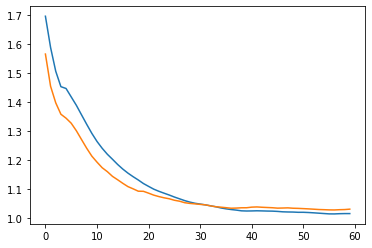

In [57]:
plt.plot(avg_training_losses)
plt.plot(avg_val_losses)

In [58]:
a, b = [], []

for x, y in valloader:
    x, y = x.to(device), y.to(device)
    x = x.float()
    y_pred = model(x)
    y_pred, y = y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()
    yes = np.argmax(y_pred, axis=1)
    a.append(yes)
    b.append(y)

In [59]:
count = 0
for i, j in zip(a, b):
    for k, l in zip(i, j):
        if k == l:
            count += 1
count/2808

0.5544871794871795